✓ TensorFlow Op Determinism Enabled
--- Processing hdfc (Optimized + Cleaner Grid) ---
Training BILSTM (LR=0.003, Clip=1.0)...
Training TCN (LR=0.003, Clip=None)...
Training TCN_BILSTM (LR=0.003, Clip=None)...

================ METRICS (Scaled Axis) ================

BILSTM:
  MAE : 14.9026
  MSE : 337.3786
  RMSE: 18.3679
  R²  : 0.9614

TCN:
  MAE : 28.3868
  MSE : 1180.9362
  RMSE: 34.3648
  R²  : 0.8648

TCN_BILSTM:
  MAE : 10.7901
  MSE : 194.5914
  RMSE: 13.9496
  R²  : 0.9777
Plot saved to prediction/hdfc/results_optimized_scaled.png


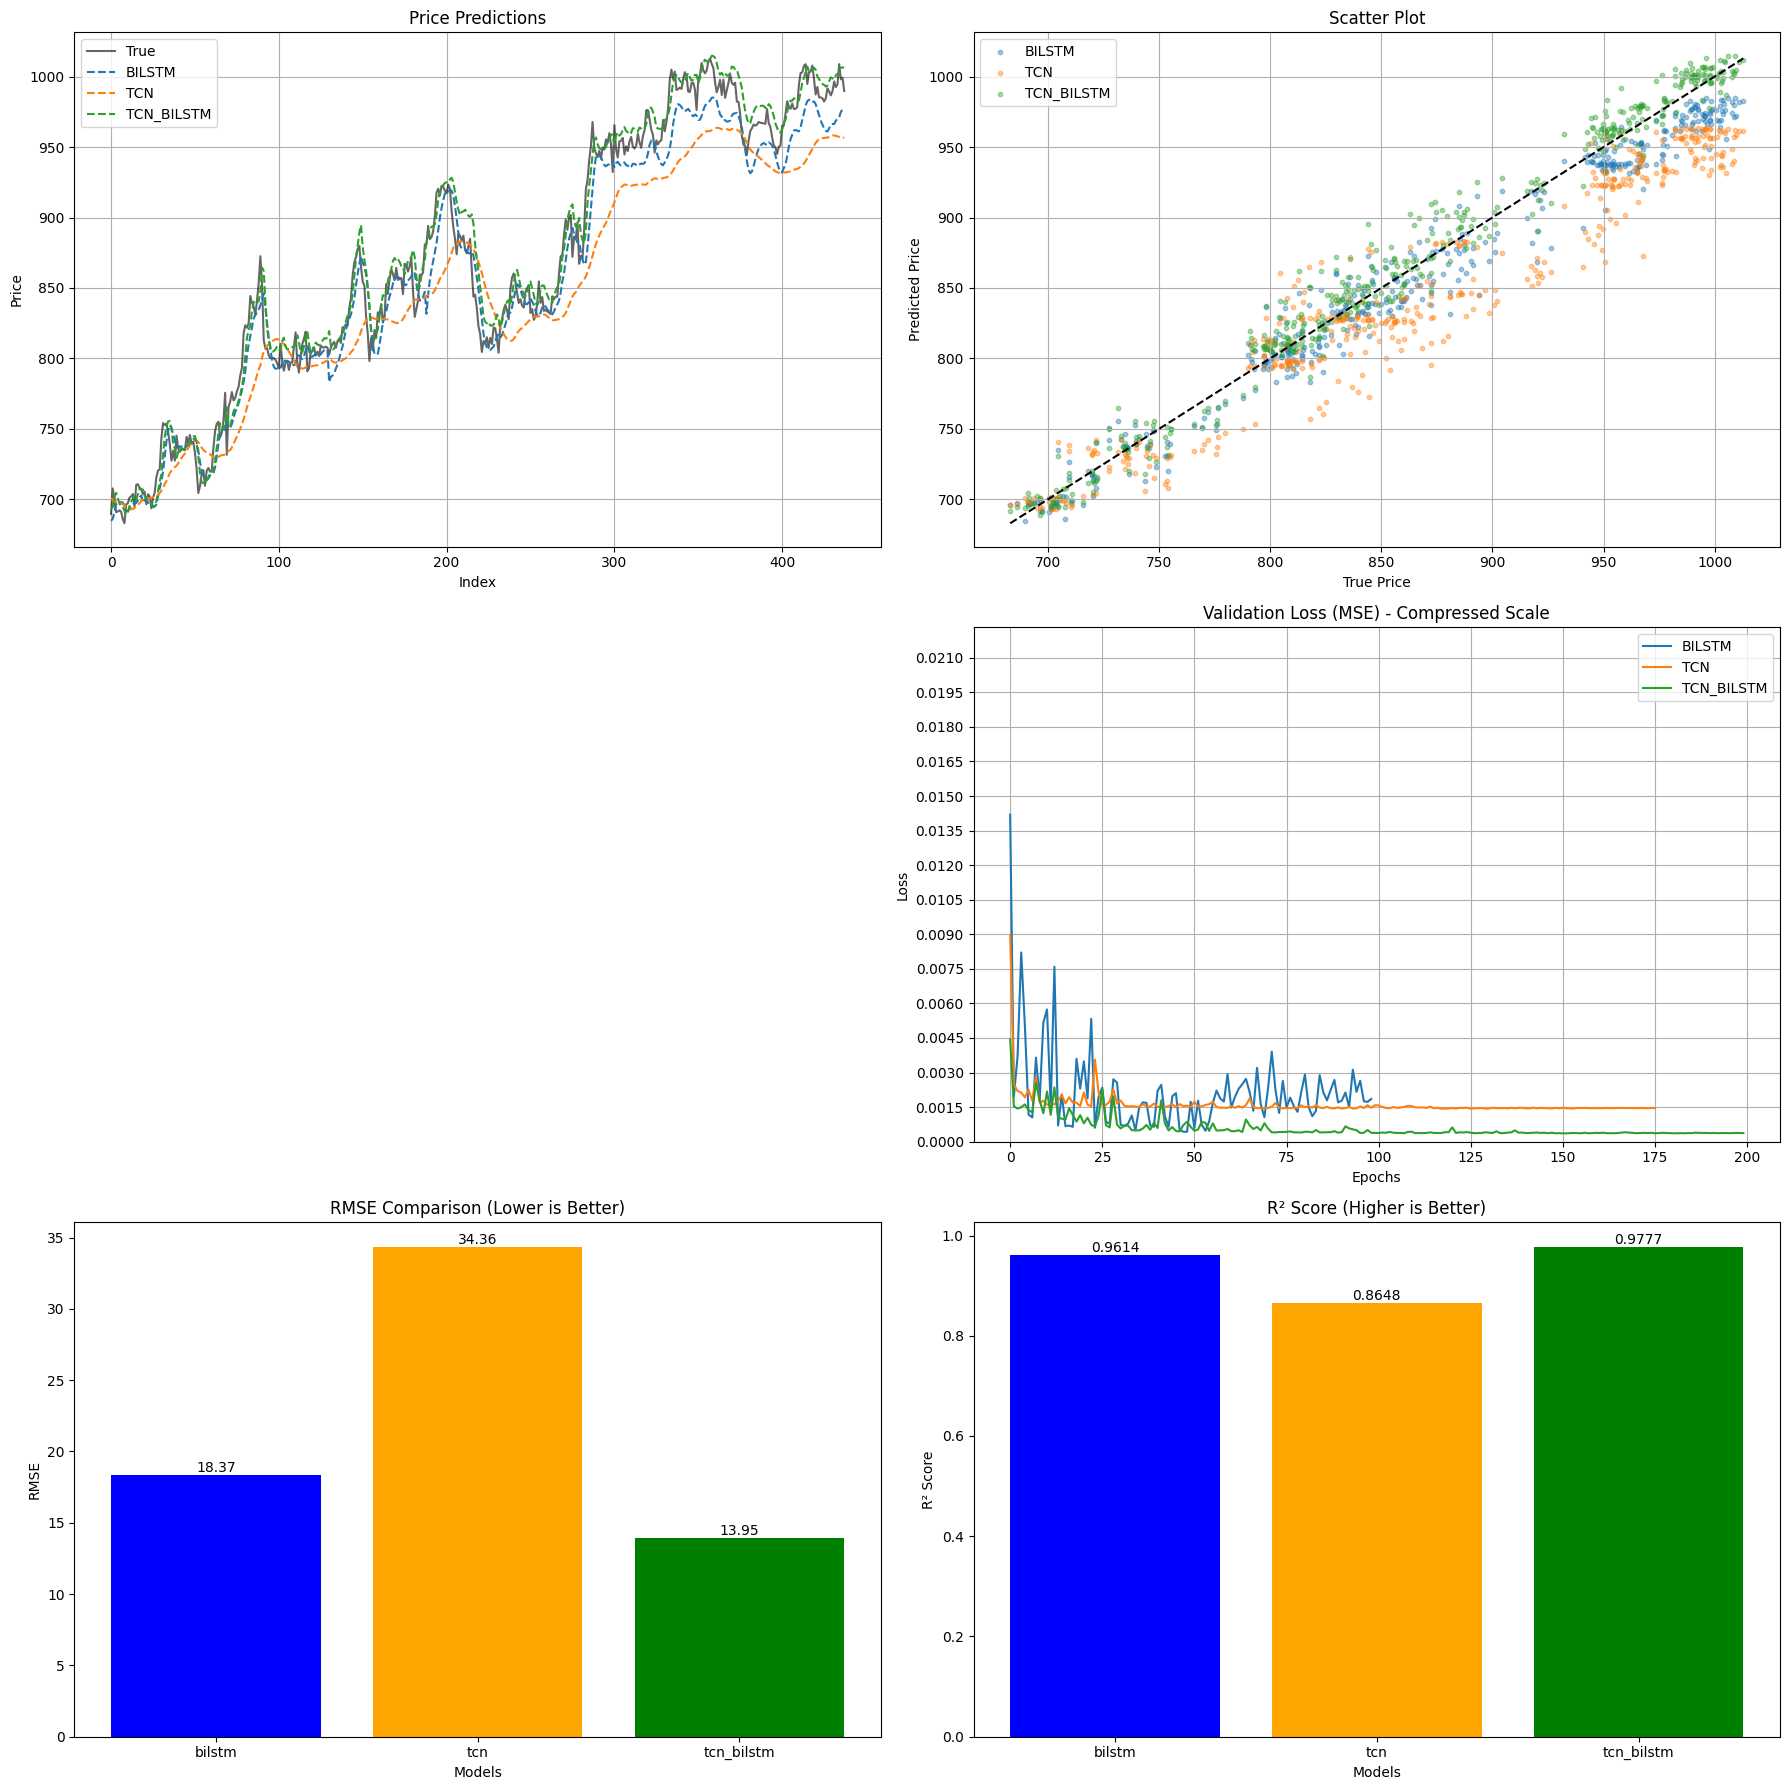

--- Processing infosys (Optimized + Cleaner Grid) ---
Training BILSTM (LR=0.003, Clip=1.0)...
Training TCN (LR=0.003, Clip=None)...
Training TCN_BILSTM (LR=0.003, Clip=None)...

================ METRICS (Scaled Axis) ================

BILSTM:
  MAE : 37.9059
  MSE : 2423.2988
  RMSE: 49.2270
  R²  : 0.9206

TCN:
  MAE : 57.9463
  MSE : 5151.9575
  RMSE: 71.7771
  R²  : 0.8312

TCN_BILSTM:
  MAE : 24.3486
  MSE : 1051.2489
  RMSE: 32.4230
  R²  : 0.9656
Plot saved to prediction/infosys/results_optimized_scaled.png


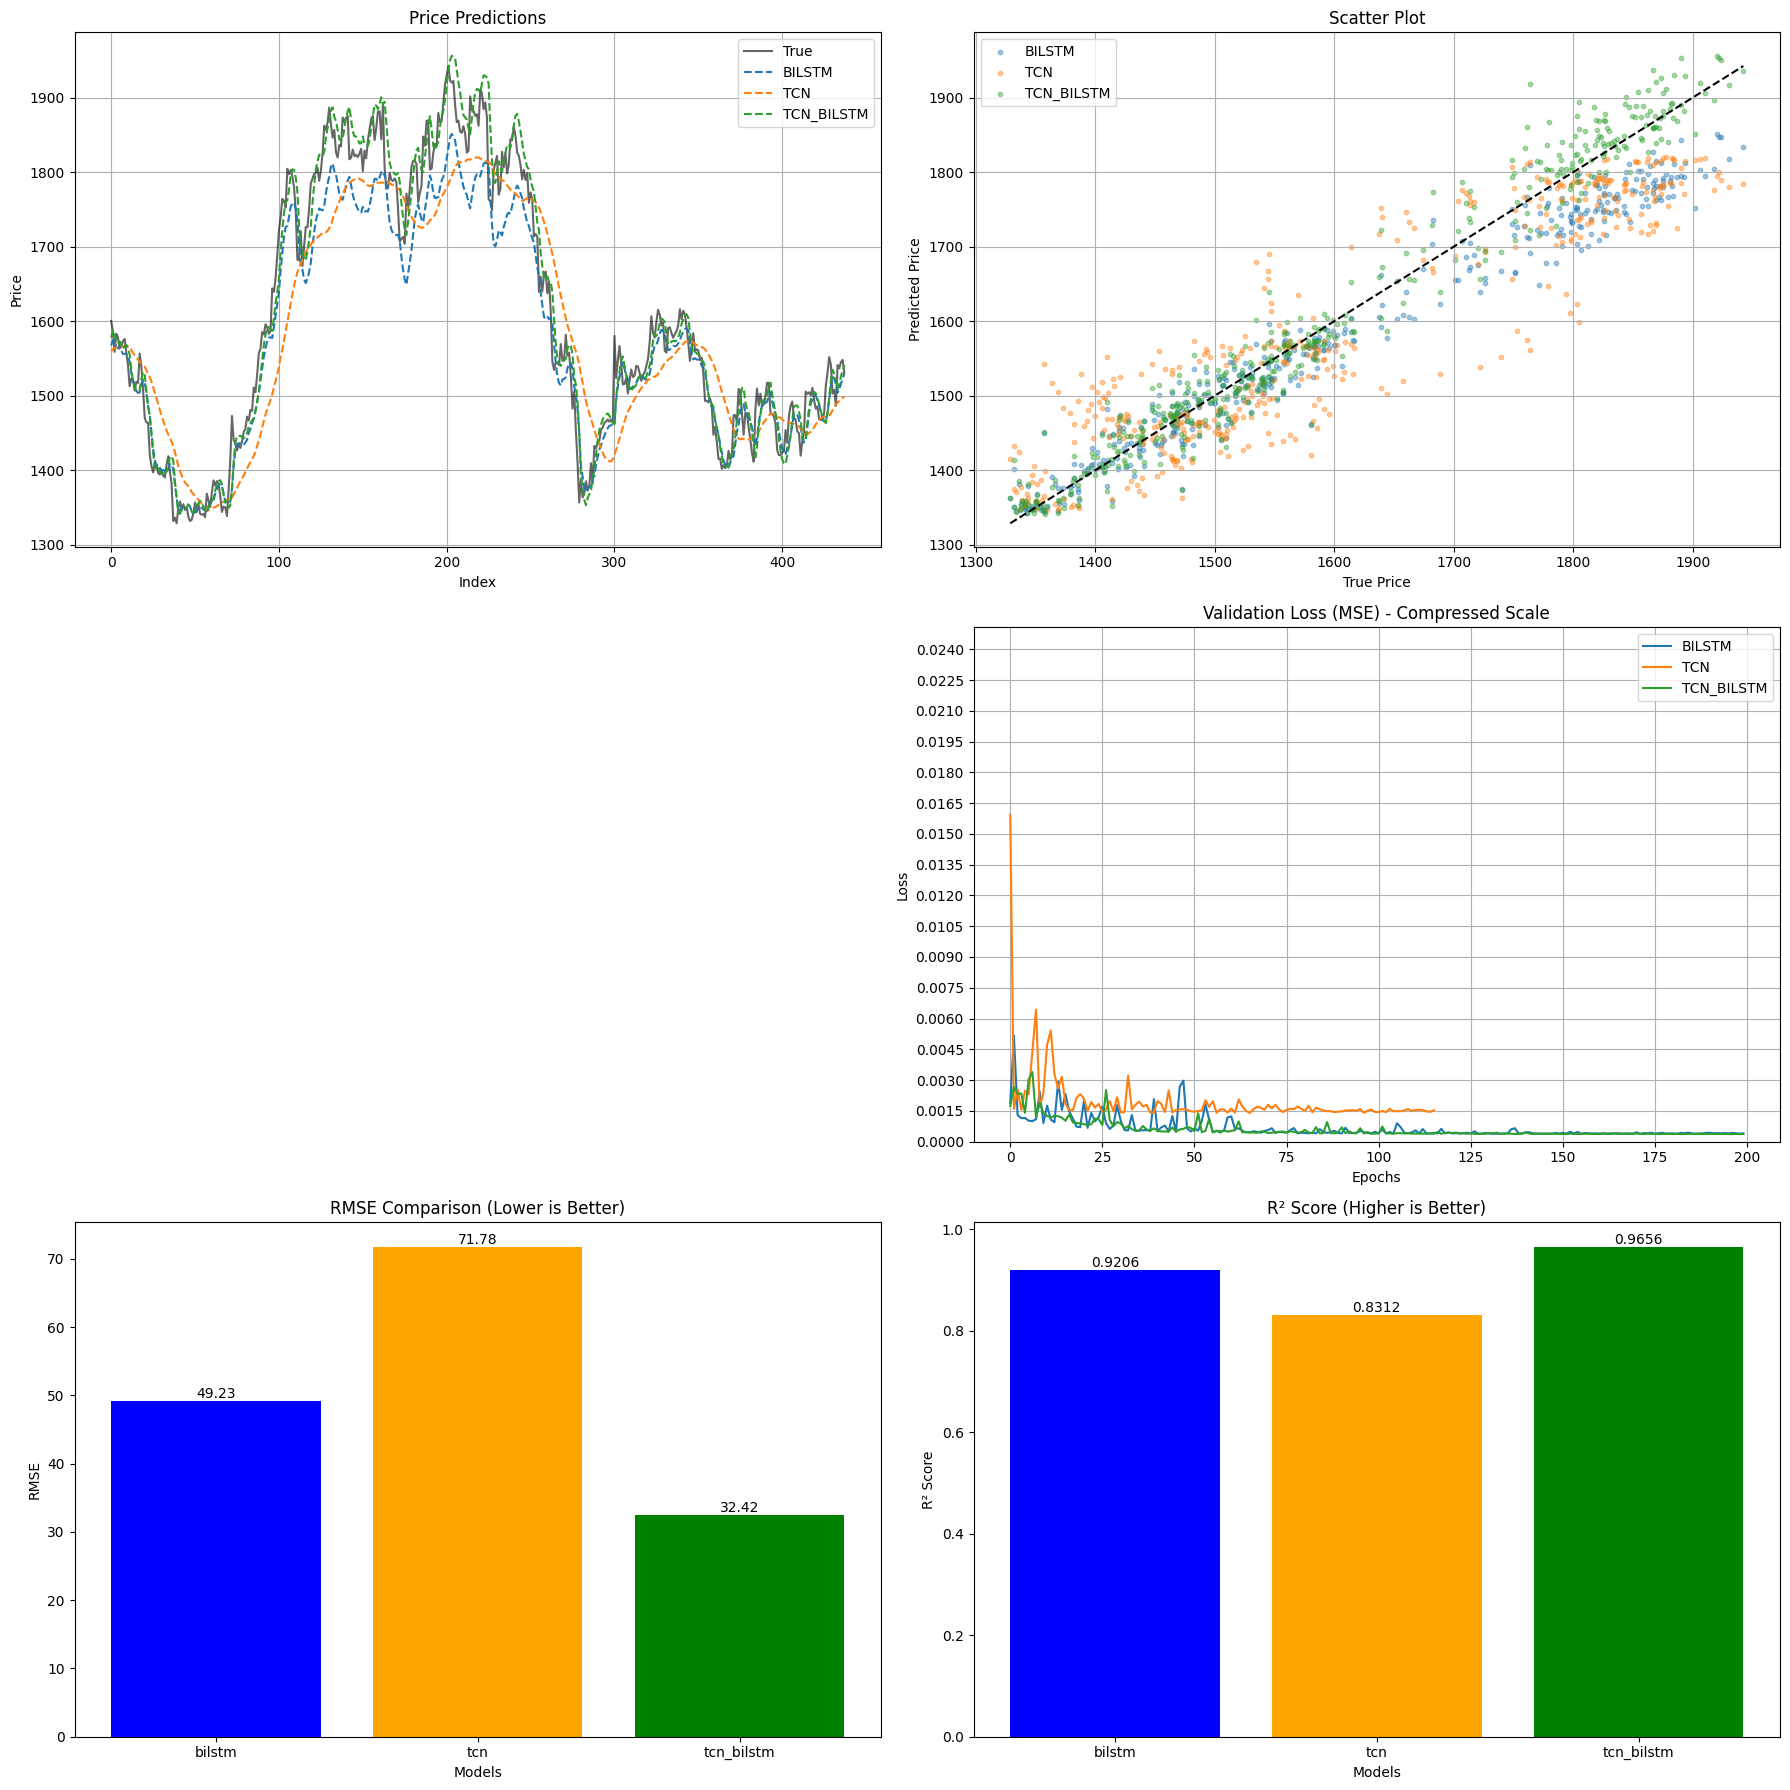

--- Processing tcs (Optimized + Cleaner Grid) ---
Training BILSTM (LR=0.003, Clip=1.0)...
Training TCN (LR=0.003, Clip=None)...
Training TCN_BILSTM (LR=0.003, Clip=None)...

================ METRICS (Scaled Axis) ================

BILSTM:
  MAE : 72.3964
  MSE : 8870.6758
  RMSE: 94.1843
  R²  : 0.9482

TCN:
  MAE : 119.1501
  MSE : 25471.4688
  RMSE: 159.5978
  R²  : 0.8512

TCN_BILSTM:
  MAE : 71.5989
  MSE : 8221.6133
  RMSE: 90.6731
  R²  : 0.9520
Plot saved to prediction/tcs/results_optimized_scaled.png


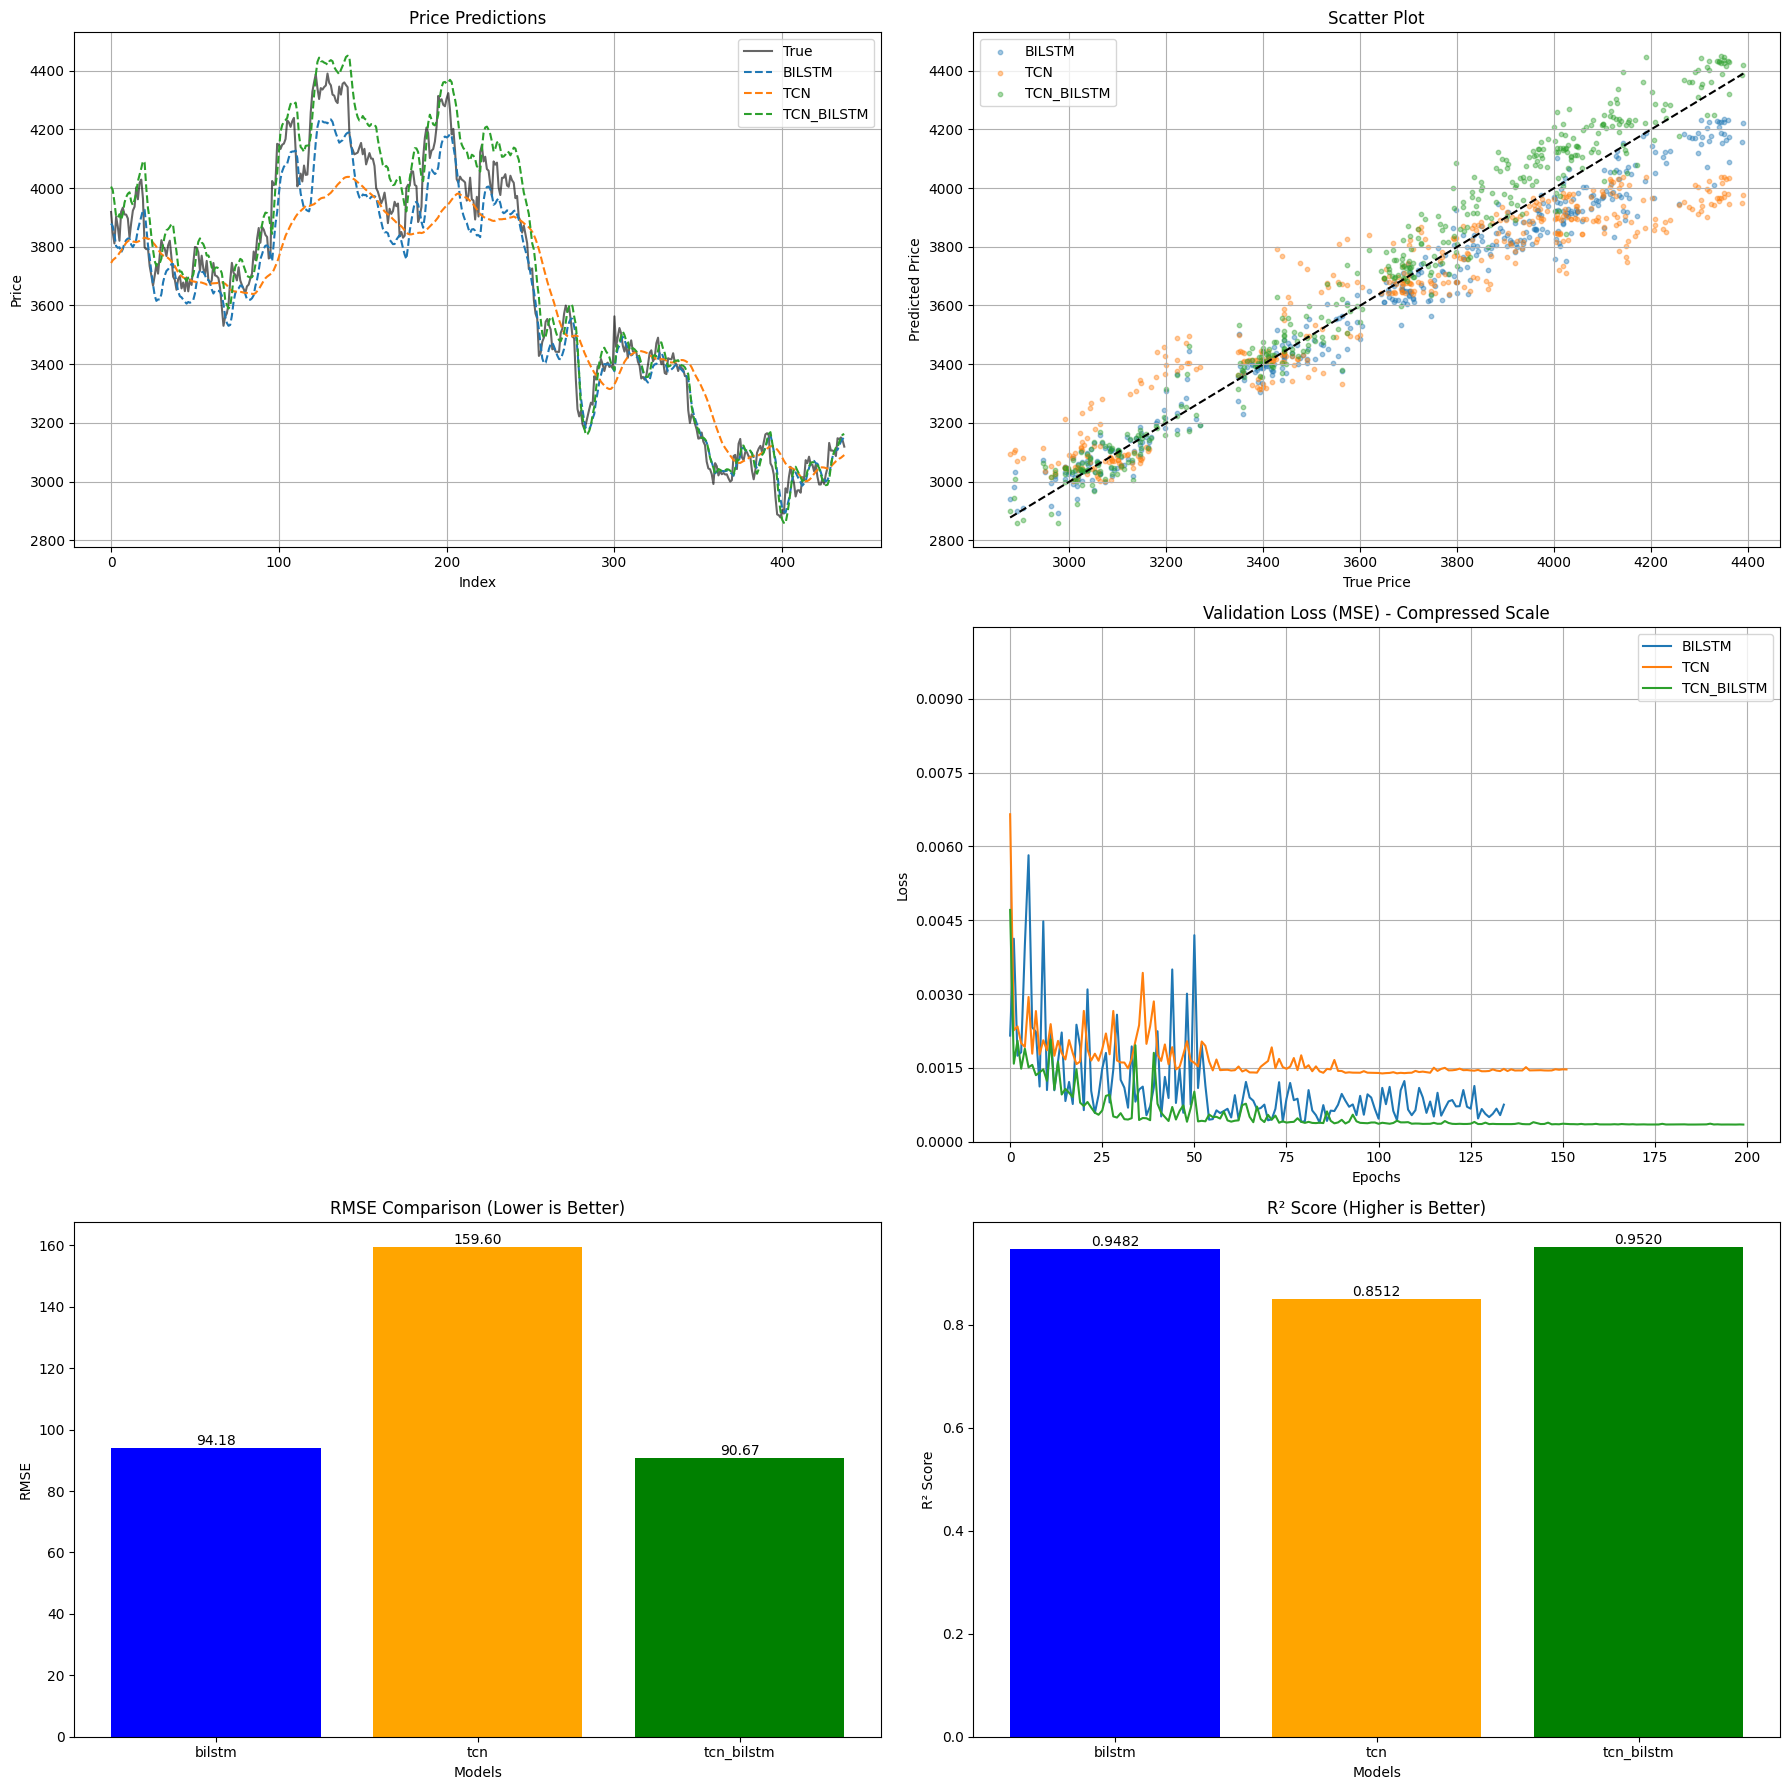

--- Processing reliance (Optimized + Cleaner Grid) ---
Training BILSTM (LR=0.003, Clip=1.0)...
Training TCN (LR=0.003, Clip=None)...
Training TCN_BILSTM (LR=0.003, Clip=None)...

================ METRICS (Scaled Axis) ================

BILSTM:
  MAE : 21.9827
  MSE : 748.9749
  RMSE: 27.3674
  R²  : 0.9256

TCN:
  MAE : 37.6679
  MSE : 2305.8010
  RMSE: 48.0188
  R²  : 0.7710

TCN_BILSTM:
  MAE : 19.9437
  MSE : 653.2214
  RMSE: 25.5582
  R²  : 0.9351
Plot saved to prediction/reliance/results_optimized_scaled.png


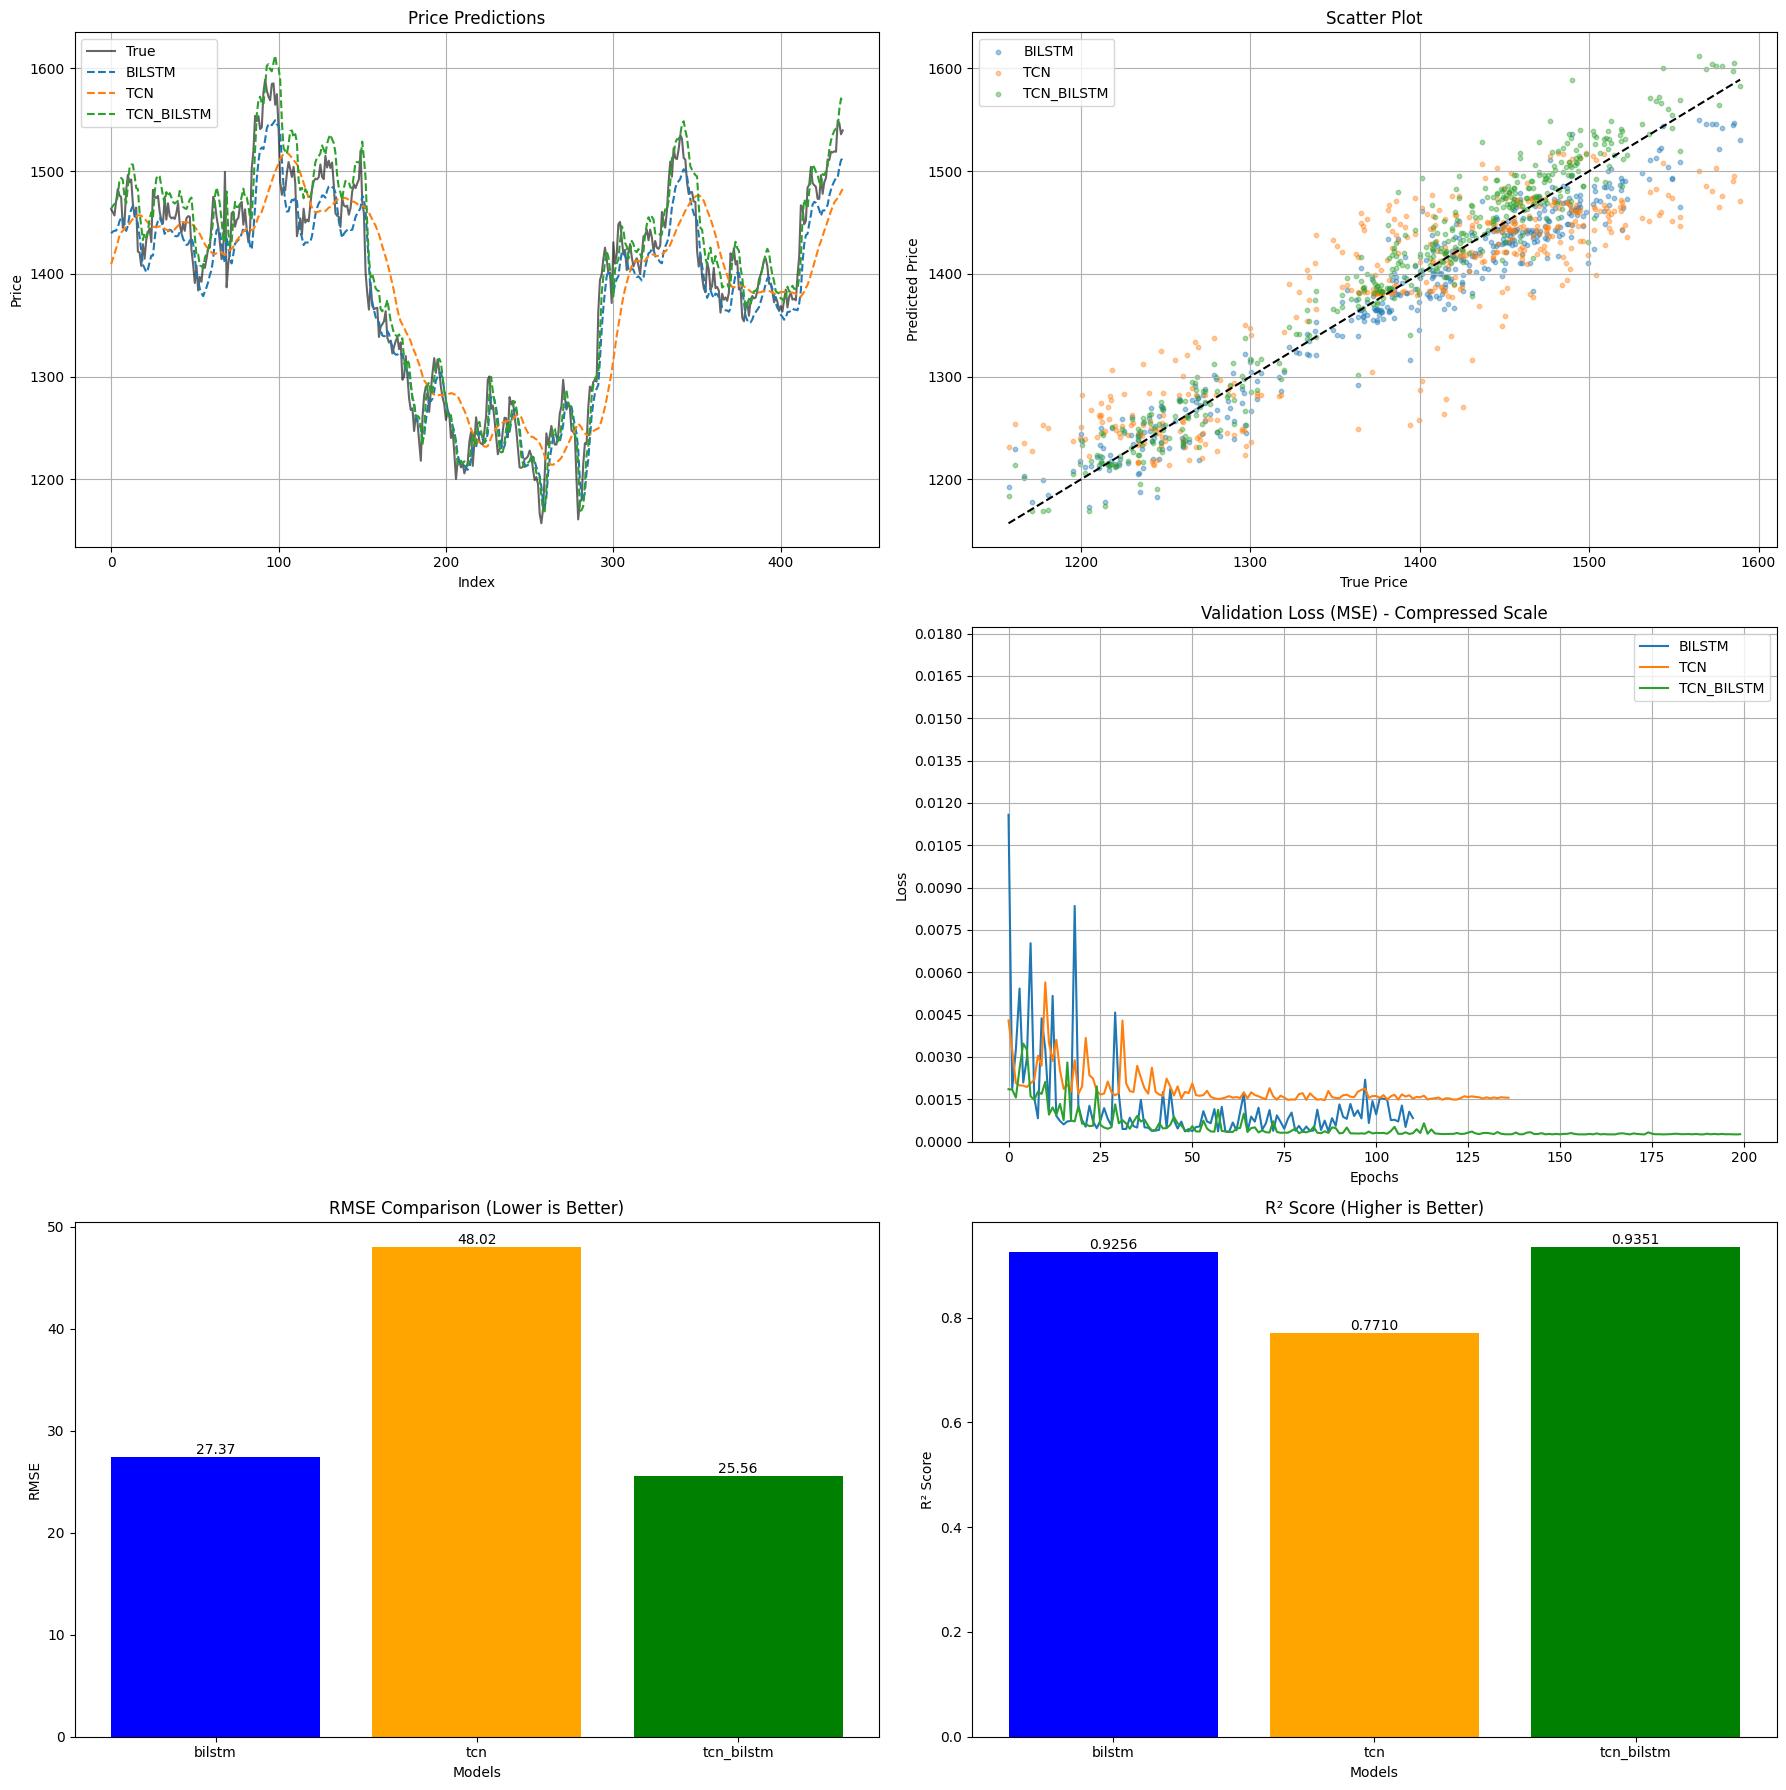


✓ DONE — Training with Cleaner Grid completed.


In [2]:
import os
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

# NEW IMPORT for custom grid spacing
from matplotlib.ticker import MultipleLocator

# ---------------------------------
# 1. STRICT REPRODUCIBILITY SETUP
# ---------------------------------
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import tensorflow as tf

try:
    tf.config.experimental.enable_op_determinism()
    print("✓ TensorFlow Op Determinism Enabled")
except AttributeError:
    print("! Warning: Your TensorFlow version might be too old for enable_op_determinism()")

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------------------------------
# Utility Functions
# ---------------------------------

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)

def rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def calc_r2_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + 1e-9)

# ---------------------------------
# Data Loading & Prep
# ---------------------------------

def candidate_paths(stock):
    s = stock.lower()
    base = f"data/{s}"
    return {
        "old": f"{base}/data_harga_{s}.csv",
        "new": f"{base}/price_data_{s}.csv",
        "base": base,
    }

def fetch_price_yf(stock, start="2014-01-01", end=None, auto_adjust=True):
    ticker_map = {
        "reliance": "RELIANCE.NS", "tcs": "TCS.NS",
        "infosys": "INFY.NS", "hdfc": "HDFCBANK.NS",
    }
    ticker = ticker_map.get(stock.lower(), f"{stock.upper()}.NS")
    if end is None: end = datetime.today().strftime("%Y-%m-%d")

    print(f"Fetching {ticker} from yfinance: {start} -> {end}")
    t = yf.Ticker(ticker)
    try:
        df = t.history(start=start, end=end, auto_adjust=auto_adjust)
    except Exception as e:
        print("Error fetching:", e)
        return pd.DataFrame()

    if df.empty: return df
    df = df.reset_index().rename(columns={"Date": "Date"})
    return df

def safe_load_price(stock):
    stock = stock.lower()
    cp = candidate_paths(stock)
    ensure_dir(cp["base"])

    if os.path.exists(cp["old"]): return pd.read_csv(cp["old"])
    if os.path.exists(cp["new"]): return pd.read_csv(cp["new"])

    df = fetch_price_yf(stock)
    if df.empty:
        idx = pd.date_range(start="2014-01-01", periods=1000, freq='B')
        base_price = 100 + np.cumsum(np.random.randn(len(idx)) * 2)
        base_price = np.clip(base_price, 10, None)
        df = pd.DataFrame({
            "Date": idx,
            "Open": base_price * 1.01, "High": base_price * 1.02,
            "Low": base_price * 0.98, "Close": base_price, "Volume": 100000
        })
    df.to_csv(cp["new"], index=False)
    return df

def preprocess_price_data(df):
    cols = ["Open", "High", "Low", "Close", "Volume"]
    df = df[[c for c in cols if c in df.columns]].ffill().bfill()
    return df.reset_index(drop=True)

# ---------------------------------
# Windowing & Dataset
# ---------------------------------

def make_windows(df, window, target_col="Close"):
    if target_col not in df.columns: target_col = "Close"
    cols = [target_col] + [c for c in df.columns if c != target_col]
    data = df[cols].values

    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window, 0])

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32).reshape(-1, 1)

def make_tf_dataset(X, y, batch=32, shuffle=True, seed=29):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(min(1000, len(X)), seed=seed)
    return ds.batch(batch)

# ---------------------------------
# Layers & Models
# ---------------------------------

class PositionalEncodingLayer(tf.keras.layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        pos = np.arange(seq_len)[:, None]
        i = np.arange(d_model)[None, :]
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / d_model)
        angles = pos * angle_rates
        angles[:, 0::2] = np.sin(angles[:, 0::2])
        angles[:, 1::2] = np.cos(angles[:, 1::2])
        self.pe = tf.cast(angles[None, ...], tf.float32)

    def call(self, x):
        return x + self.pe[:, :tf.shape(x)[1], :tf.shape(x)[2]]

    def get_config(self): return super().get_config()

# ---------------------------------------------------------
# OPTIMIZER FACTORY
# ---------------------------------------------------------
def get_optimizer(lr, clip=None):
    if clip is not None:
        return Adam(learning_rate=lr, clipvalue=clip, amsgrad=True)
    else:
        return Adam(learning_rate=lr, amsgrad=True)

def build_bilstm(shape, seed=29, lr=1e-4, clip=None):
    seq_len, d_model = shape
    inp = Input(shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.2, seed=seed)(x)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dropout(0.2, seed=seed)(x)
    x = Dense(32, activation="relu")(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=get_optimizer(lr, clip), loss="mse", metrics=["mae", "mse", rmse, calc_r2_score])
    return model

def tcn_block(x, filters, k=3, d=1, drop=0.2, final=False, seed=29):
    y = Conv1D(filters, k, padding='causal', dilation_rate=d)(x)
    y = LayerNormalization()(y)
    y = Activation("relu")(y)
    y = Dropout(drop, seed=seed)(y)
    res = Conv1D(filters, 1, padding='same')(x)
    out = Add()([y, res])
    if final: out = GlobalAveragePooling1D()(out)
    return out

def build_tcn(shape, seed=29, lr=1e-3, clip=None):
    seq_len, d_model = shape
    inp = Input(shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)
    x = tcn_block(x, 64, 5, 1, 0.2, False, seed)
    x = tcn_block(x, 64, 3, 2, 0.2, False, seed)
    x = tcn_block(x, 32, 3, 4, 0.2, True, seed)
    x = Dense(32, activation="relu")(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=get_optimizer(lr, clip), loss="mse", metrics=["mae", "mse", rmse, calc_r2_score])
    return model

def build_tcn_bilstm(shape, seed=29, lr=1e-3, clip=None):
    seq_len, d_model = shape
    inp = Input(shape)
    x = PositionalEncodingLayer(seq_len, d_model)(inp)
    t = tcn_block(x, 32, 5, 1, 0.2, False, seed)
    t = tcn_block(t, 32, 3, 2, 0.2, True, seed)
    b = Bidirectional(LSTM(64, return_sequences=False))(x)
    b = Dropout(0.2, seed=seed)(b)
    c = Concatenate()([t, b])
    c = Dense(32, activation="relu")(c)
    out = Dense(1)(c)
    model = Model(inp, out)
    model.compile(optimizer=get_optimizer(lr, clip), loss="mse", metrics=["mae", "mse", rmse, calc_r2_score])
    return model

# ---------------------------------
# Training
# ---------------------------------

def train_single_seed(stock, window, batch, epochs,
                      X_train_s, y_train_s, X_val_s, y_val_s,
                      X_test_s, y_test_s, target_scaler, shape):
    seed = 29
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    train_ds = make_tf_dataset(X_train_s, y_train_s, batch=batch, seed=seed)
    val_ds   = make_tf_dataset(X_val_s,   y_val_s,   batch=batch, shuffle=False)

    # ---------------------------------------------------------
    # CONFIG: Optimized Settings Per Model
    # ---------------------------------------------------------
    model_configs = {
        "bilstm": {
            "func": build_bilstm,
            "lr": 3e-3,
            "clip": 1.0
        },
        "tcn": {
            "func": build_tcn,
            "lr": 3e-3,
            "clip": None
        },
        "tcn_bilstm": {
            "func": build_tcn_bilstm,
            "lr": 3e-3,
            "clip": None
        }
    }

    models = {}
    results = {}

    for name, config in model_configs.items():
        print(f"Training {name.upper()} (LR={config['lr']}, Clip={config['clip']})...")
        model = config["func"](shape, seed, lr=config["lr"], clip=config["clip"])
        models[name] = model

        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            verbose=0,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=20)
            ]
        )

        y_pred_s = model.predict(X_test_s, verbose=0)
        y_true = target_scaler.inverse_transform(y_test_s).flatten()
        y_pred = target_scaler.inverse_transform(y_pred_s).flatten()
        mse = mean_squared_error(y_true, y_pred)

        results[name] = {
            "y_true": y_true, "y_pred": y_pred, "mae": mean_absolute_error(y_true, y_pred),
            "mse": mse, "rmse": math.sqrt(mse), "r2": r2_score(y_true, y_pred),
            "history": history.history
        }

    return models, results

# ---------------------------------
# Plotting (FIXED: Visual Compression)
# ---------------------------------

def plot_results(results, stock):
    print("\n================ METRICS (Scaled Axis) ================")
    for name, r in results.items():
        print(f"\n{name.upper()}:")
        print(f"  MAE : {r['mae']:.4f}")
        print(f"  MSE : {r['mse']:.4f}")
        print(f"  RMSE: {r['rmse']:.4f}")
        print(f"  R²  : {r['r2']:.4f}")

    fig = plt.figure(figsize=(18, 18))

    # 1. Predictions
    ax1 = plt.subplot(3, 2, 1)
    y_true = results["bilstm"]["y_true"]
    ax1.plot(y_true, label="True", color='black', alpha=0.6)
    for name, r in results.items():
        ax1.plot(r["y_pred"], label=name.upper(), linestyle='--')
    ax1.set_xlabel("Index"); ax1.set_ylabel("Price")
    ax1.set_title("Price Predictions")
    ax1.legend(); ax1.grid(True)

    # 2. Scatter
    ax2 = plt.subplot(3, 2, 2)
    for name, r in results.items():
        ax2.scatter(y_true, r["y_pred"], alpha=0.4, label=name.upper(), s=10)
    lim = [y_true.min(), y_true.max()]
    ax2.plot(lim, lim, 'k--')
    ax2.set_xlabel("True Price"); ax2.set_ylabel("Predicted Price")
    ax2.set_title("Scatter Plot")
    ax2.legend(); ax2.grid(True)


    # 4. Val Loss (SCALED)
    ax4 = plt.subplot(3, 2, 4)
    for name, r in results.items():
        ax4.plot(r['history']['val_loss'], label=f"{name.upper()}")
    ax4.set_title("Validation Loss (MSE) - Compressed Scale")
    ax4.set_xlabel("Epochs"); ax4.set_ylabel("Loss")
    ax4.legend(); ax4.grid(True)

    # FIX: Same compression for Validation
    bottom, top = ax4.get_ylim()
    new_top = max(top * 1.5, 0.01) # Double the range = Half the visual height
    ax4.set_ylim(0, new_top)

    # Set Grid lines to every 0.0015
    ax4.yaxis.set_major_locator(MultipleLocator(0.0015))

    # 5. RMSE
    ax5 = plt.subplot(3, 2, 5)
    models_list = list(results.keys())
    rmse_vals = [results[m]["rmse"] for m in models_list]
    bars = ax5.bar(models_list, rmse_vals, color=['blue', 'orange', 'green'])
    ax5.bar_label(bars, fmt='%.2f')
    ax5.set_xlabel("Models"); ax5.set_ylabel("RMSE")
    ax5.set_title("RMSE Comparison (Lower is Better)")

    # 6. R2
    ax6 = plt.subplot(3, 2, 6)
    r2_vals = [results[m]["r2"] for m in models_list]
    bars = ax6.bar(models_list, r2_vals, color=['blue', 'orange', 'green'])
    ax6.bar_label(bars, fmt='%.4f')
    ax6.set_xlabel("Models"); ax6.set_ylabel("R² Score")
    ax6.set_title("R² Score (Higher is Better)")

    plt.tight_layout()
    ensure_dir(f"prediction/{stock}")
    save_path = f"prediction/{stock}/results_optimized_scaled.png"
    plt.savefig(save_path, dpi=300)
    print(f"Plot saved to {save_path}")
    plt.show()


# ---------------------------------
# Main
# ---------------------------------

if __name__ == "__main__":
    STOCKS = ["hdfc", "infosys","tcs", "reliance"]

    # GLOBAL SETTING: Batch Size 64
    WINDOW, BATCH, EPOCHS = 20, 64, 200

    for stock in STOCKS:
        print(f"--- Processing {stock} (Optimized + Cleaner Grid) ---")
        df = safe_load_price(stock)
        df = preprocess_price_data(df)
        ensure_dir(f"prediction/{stock}")
        ensure_dir(f"saved_models/{stock}")

        X, y = make_windows(df, WINDOW)
        n = len(X)
        t1, t2 = int(0.7 * n), int(0.85 * n)

        X_train, y_train = X[:t1], y[:t1]
        X_val,   y_val    = X[t1:t2], y[t1:t2]
        X_test,  y_test   = X[t2:],   y[t2:]

        f_scaler, t_scaler = MinMaxScaler(), MinMaxScaler()
        X_train_s = f_scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
        y_train_s = t_scaler.fit_transform(y_train)
        X_val_s = f_scaler.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)
        y_val_s = t_scaler.transform(y_val)
        X_test_s = f_scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)
        y_test_s = t_scaler.transform(y_test)

        models, results = train_single_seed(
            stock, WINDOW, BATCH, EPOCHS,
            X_train_s, y_train_s, X_val_s, y_val_s,
            X_test_s, y_test_s, t_scaler, (WINDOW, X.shape[2])
        )

        for name, r in results.items():
            pd.DataFrame({"y_true": r["y_true"], "y_pred": r["y_pred"]}).to_csv(f"prediction/{stock}/{name}_pred.csv", index=False)
            pd.DataFrame(r['history']).to_csv(f"prediction/{stock}/{name}_loss.csv")

        plot_results(results, stock)

    print("\n✓ DONE — Training with Cleaner Grid completed.")